# Emissions Intensity Analysis

The goal of this script is to determine which plants have increased emissions intensity, which have decreased, why the emissions intensity has changed, and by how much. We start by plotting the data, and looking at various aggregations.

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set()
sns.set_context("talk", rc={"font.size":16,"axes.titlesize":24,"axes.labelsize":20,"axes.suptitlesize":30})

In [184]:
EI = pd.read_csv('emissionsIntensity.csv')
print(EI.shape[0]/3)
EI.head()

725.0


,ORISPL_CODE,UNITID,NAME,FUEL,GAS,2001,2002,2003,2004,2005,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,87,1,Escalante,coal,CO2,1.140423,0.995313,0.917968,0.989163,1.009391,...,1.105578,1.139843,1.177716,1.144533,1.105952,1.050198,0.996492,1.036716,1.056700,1.062672
1,87,1,Escalante,coal,SO2,1.554520,1.348214,1.188432,1.276701,1.268912,...,1.336621,1.356052,1.428336,1.305897,1.169239,0.980457,1.158256,1.281471,1.274391,1.195515
2,87,1,Escalante,coal,NOX,4.300777,3.925008,3.559608,3.884382,3.725776,...,3.685115,3.481987,3.846905,3.747445,3.733149,3.455141,3.351200,3.475148,3.608294,3.741219
3,113,1,Cholla,coal,CO2,1.167588,1.170753,1.106735,1.060301,1.047829,...,1.178634,1.154394,1.134915,1.127551,1.147178,1.152896,1.170352,1.313986,1.287809,1.302087
4,113,1,Cholla,coal,SO2,2.047569,2.166203,1.706805,1.632499,1.614211,...,1.216816,1.658520,2.233263,1.521215,1.485904,1.407100,1.333497,1.256306,1.141691,1.026894


#### Filter to manage missing data

Investigate how much of the plant data is missing.

In [185]:
print('Units included: ', EI.shape[0]/3)  # 3 rows for each, because we have CO2, SO2, and NOx
EI_01_18 = EI.dropna()
print('Units with data for 2001 - 2018: ', EI_01_18.shape[0]/3)
EI_01_18.head()
print('Units missing metadata: ', EI.shape[0]/3 - EI.dropna(subset=['ORISPL_CODE', 'UNITID', 'NAME', 'GAS']).shape[0]/3)

Units included:  725.0
Units with data for 2001 - 2018:  179.0
Units missing metadata:  0.0


Remove plants with less than 5 years of data

In [186]:
EI_5 = EI.copy()  # have to make a new df! Otherwise 'inplace' kwarg edits OG df too.
for ind, row in EI_5.iterrows():
    if sum(row.isnull()) > 10:
        EI_5.drop(ind, axis=0, inplace=True)
print(EI_5.shape[0]/3)
print(EI.shape[0]/3)

574.0
725.0


In [187]:
print('Units missing more than 10 years of EI data: ', EI.shape[0]/3 - EI_5.shape[0]/3)

Units missing more than 10 years of EI data:  151.0


In [188]:
# # works, but wrong df output
# EI_5 = EI
# EI_5 = [EI_5.drop(ind) for ind, row in EI_5.iterrows() if sum(row.isnull()) > 5]

Change inf to nan

In [189]:
EI_5.replace([np.inf, -np.inf], np.nan, inplace=True)

Separate fuel sources

In [260]:
gas = EI_5[EI_5['FUEL'] == 'NG']
print(gas.shape[0]/3)
coal = EI_5[EI_5['FUEL'] == 'coal']
print(coal.shape[0]/3)

485.0
89.0


How many of each gas have data for all 17 years?

In [241]:
print('Gas: ', gas.dropna().shape[0]/3)
print('Coal: ', coal.dropna().shape[0]/3)

Gas:  117.0
Coal:  59.0


Separate gases

In [191]:
# gas
CO2I_gas = gas[gas['GAS'] == 'CO2']
SO2I_gas = gas[gas['GAS'] == 'SO2']
NOXI_gas = gas[gas['GAS'] == 'NOX']
# coal
CO2I_coal = coal[coal['GAS'] == 'CO2']
SO2I_coal = coal[coal['GAS'] == 'SO2']
NOXI_coal = coal[coal['GAS'] == 'NOX']

In [192]:
# years = ['2001', '2002', '2003', '2004', '2005', '2006', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
years = np.linspace(2001, 2018, 18)

In [193]:
CO2I_gas.iloc[:, 4:]

,GAS,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
306,CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
309,CO2,0.623169,0.653750,0.656862,0.653971,0.663498,0.658999,0.659632,0.768458,0.713531,0.713683,0.715679,0.711671,0.706018,0.720569,0.689294,0.689300,0.680535,0.683992
312,CO2,0.620404,0.658447,0.665174,0.625278,0.668851,0.661172,0.667873,0.750350,0.703249,0.732647,0.724911,0.736383,0.715047,0.762688,0.698397,0.727578,0.748639,0.790039
315,CO2,0.474781,0.479720,0.483489,0.516867,0.760413,0.750939,0.506190,0.513169,0.519856,0.512151,0.518340,0.522882,0.514819,0.517731,0.509910,0.494909,0.493419,0.486895
318,CO2,NaN,NaN,0.666746,0.662775,0.668656,0.672740,0.479543,0.446883,0.456814,0.446406,0.445931,0.439843,0.446997,0.459097,0.464581,0.464688,0.469385,0.466353
321,CO2,NaN,NaN,0.666162,0.678219,0.673285,0.680537,0.484373,0.450685,0.459958,0.447819,0.445937,0.439997,0.448340,0.460579,0.464961,0.466264,0.466639,0.477000
324,CO2,0.693394,0.646674,0.722745,0.667716,0.702499,0.677584,0.691192,0.873645,0.810928,NaN,0.740282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,CO2,0.714968,0.659579,0.617754,0.733186,0.723088,0.710819,0.706100,0.935948,0.889578,NaN,0.946736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,CO2,NaN,0.721351,0.770580,0.725971,0.800713,0.729055,0.774896,0.784835,0.808409,0.778480,0.770455,0.825738,0.882597,0.856768,0.817998,0.848231,0.695806,0.707242
333,CO2,0.614146,0.605024,0.622682,0.642087,0.641382,0.714923,0.681576,0.641136,0.763716,0.601121,0.682845,0.567908,0.687188,0.700306,0.672001,0.675792,0.662951,0.679643


### Aggregation

##### What has the Western Interconnection done as a whole?

1\. Emissions intensities over time

In [194]:
def plotEI_allUnits_allYears(CO2I, SO2I, NOXI, fuel):
    # axis limits
    endOfMetadata = list(CO2I_gas.columns).index('2001')
    if fuel == 'Gas':
        co2_y_min = 0
        co2_y_max = 1.5
        so2_y_min = 0
        so2_y_max = 0.02
        nox_y_min = 0
        nox_y_max = 3
    else:  # coal
        co2_y_min = 0
        co2_y_max = 1.5
        so2_y_min = 0
        so2_y_max = 10
        nox_y_min = 0
        nox_y_max = 6
    
    # plots
    fig1 = plt.figure(figsize=(18, 12))
    ax1 = plt.subplot(311)
    for i in range(CO2I.iloc[:, endOfMetadata:].shape[1]):
        plt.plot(years, CO2I.iloc[i, endOfMetadata:])
    plt.ylim([co2_y_min, co2_y_max])
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel('tons CO2 / MWh')
    plt.title('CO2 Intensity')

    ax2 = plt.subplot(312, sharex=ax1)
    for i in range(SO2I.iloc[:, endOfMetadata:].shape[1]):
        plt.plot(years, SO2I.iloc[i, endOfMetadata:])
    plt.ylim([so2_y_min, so2_y_max])
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('lbs SO2 / MWh')
    plt.title('SO2 Intensity')

    ax3 = plt.subplot(313, sharex=ax1)
    for i in range(NOXI.iloc[:, endOfMetadata:].shape[1]):
        plt.plot(years, NOXI.iloc[i, endOfMetadata:])
    plt.ylim([nox_y_min, nox_y_max])
    plt.ylabel('lbs NOX / MWh')
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.title('NOX Intensity')

    plt.suptitle(fuel + ' Units', fontsize=30)
    plt.show()

Gas

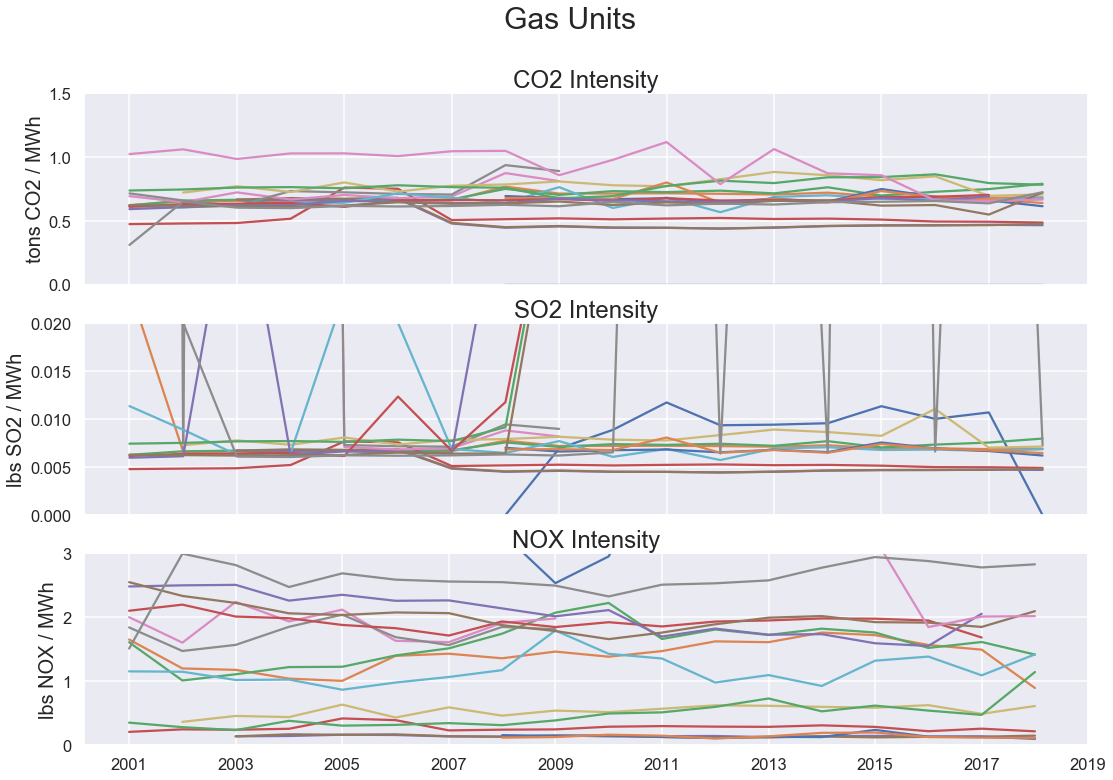

In [195]:
fuel = 'Gas'
plotEI_allUnits_allYears(CO2I_gas, SO2I_gas, NOXI_gas, fuel)

Coal

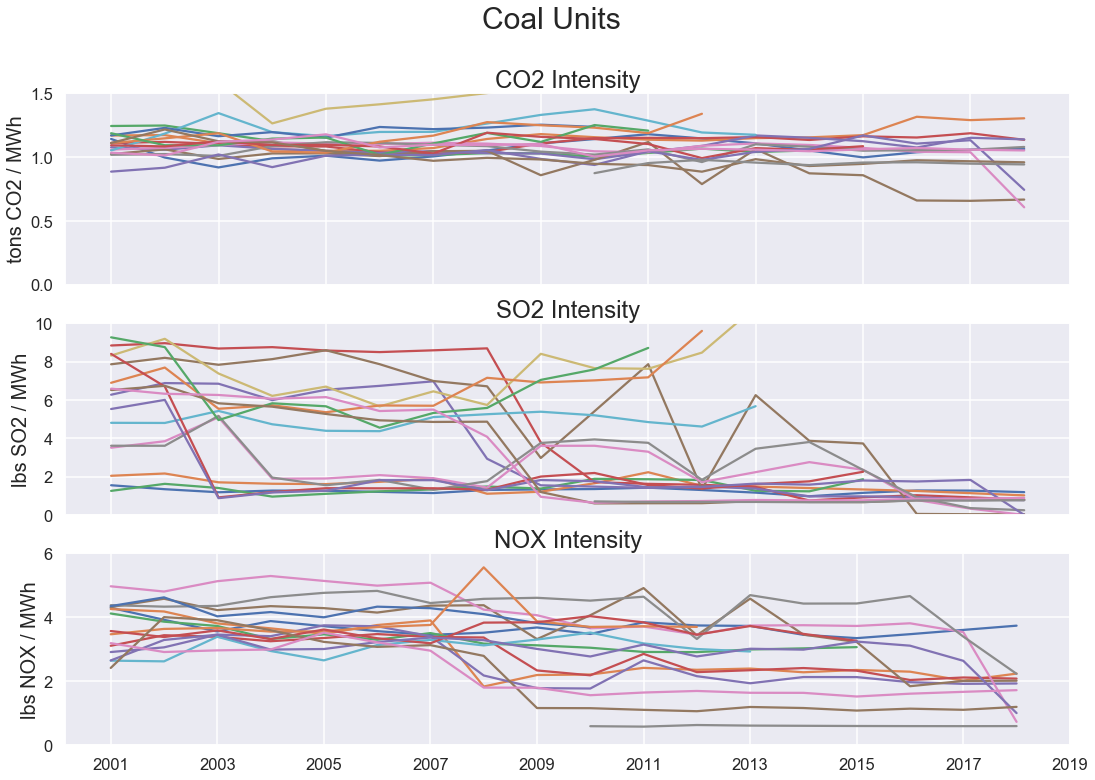

In [196]:
fuel = 'Coal'
plotEI_allUnits_allYears(CO2I_coal, SO2I_coal, NOXI_coal, fuel)

2\. Heat maps of emissions intensity

In [197]:
def plotEI_heatmap(CO2I, SO2I, NOXI, fuel):
    # axis lims
    cmap = sns.cm.rocket_r
    if fuel == 'Gas':
        co2_color_min = 0
        co2_color_max = 1
        so2_color_min = 0
        so2_color_max = 0.02
        nox_color_min = 0
        nox_color_max = 0.5
    else:  # coal
        co2_color_min = .9
        co2_color_max = 1.3
        so2_color_min = 0
        so2_color_max = 10
        nox_color_min = 0
        nox_color_max = 6

    # extract data + sort by average
    co2 = CO2I.iloc[:, endOfMetadata:]
    co2['mean'] = co2.mean(axis=1)
    co2.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

    so2 = SO2I.iloc[:, endOfMetadata:]
    so2['mean'] = so2.mean(axis=1)
    so2.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

    nox = NOXI.iloc[:, endOfMetadata:]
    nox['mean'] = nox.mean(axis=1)
    nox.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

    # plot
    fig3 = plt.figure(figsize=(18, 8))
    ax1 = fig3.add_subplot(311)
    ax1 = sns.heatmap(co2, vmin=co2_color_min, vmax=co2_color_max, cmap=cmap)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel('Units')
    plt.title('CO2 Intensity')

    ax2 = fig3.add_subplot(312)
    ax2 = sns.heatmap(so2, vmin=so2_color_min, vmax=so2_color_max, cmap=cmap)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('Units')
    plt.title('SO2 Intensity')

    ax3 = fig3.add_subplot(313)
    ax3 = sns.heatmap(nox, vmin=nox_color_min, vmax=nox_color_max, cmap=cmap)
    plt.ylabel('Units')
    plt.title('NOX Intensity')

    plt.suptitle(fuel + ' Units', fontsize=30)
    plt.show()

Gas

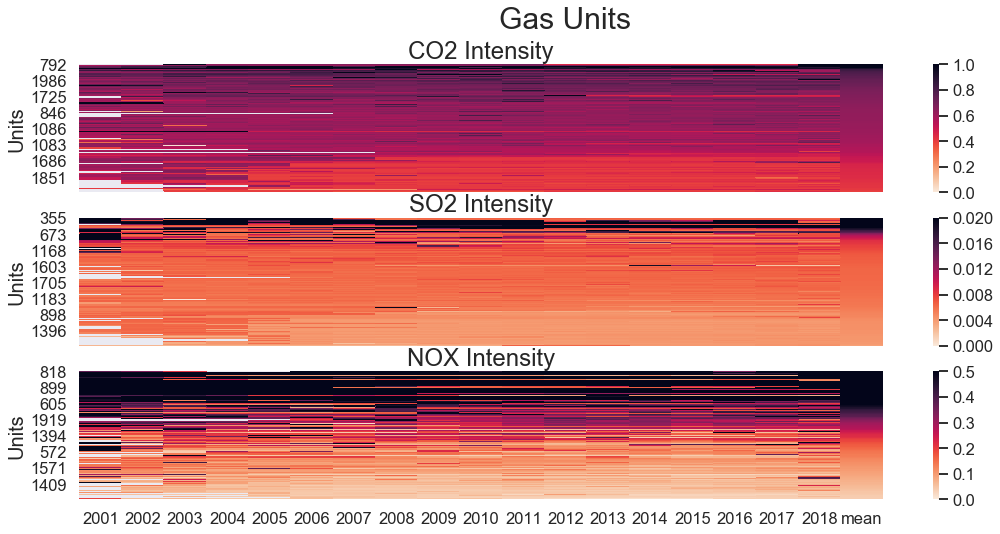

In [198]:
fuel = 'Gas'
plotEI_heatmap(CO2I_gas, SO2I_gas, NOXI_gas, fuel)

Coal

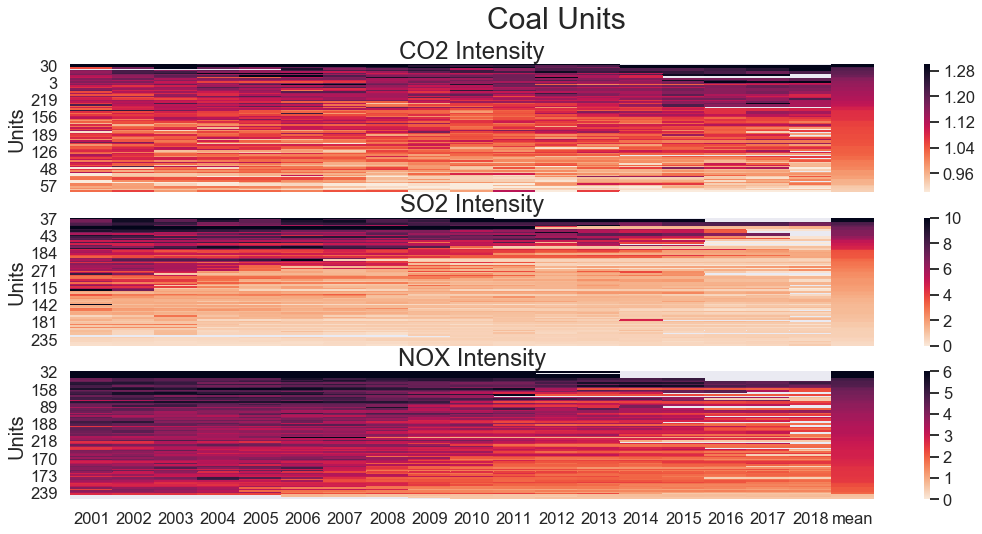

In [199]:
fuel = 'Coal'
plotEI_heatmap(CO2I_coal, SO2I_coal, NOXI_coal, fuel)

The temporal trends in NOX and SO2 are striking here. Note a few things:

1. Both SO2I and NOXI have decreased sharply since 2001.
2. For each unit, there is a step change where emissions controls are incorporated...
3. ...Or, for the worst offenders (black), there is no data in the later periods because operators chose to shutter the plants instead of upgrading emissions controls.
4. For CO2, it's very difficult to see a compelling temporal trend. However, there is a slight increase in the more CO2 intense plants, and a possible decrease in the less CO2 plants. This needs further investigation.


In [200]:
# fig2 = plt.figure(figsize=(12, 14))
# ax1 = fig2.add_subplot(311)
# ax1 = sns.clustermap(CO2I.iloc[:, 4:].fillna(0))

##### What have states done?

##### Balancing areas

## Cluster to find different emissions intensity patterns

In [407]:
def fitKMeans(data, k):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit_predict(data)
    return k_means

In [412]:
def chooseK(X):
    # X = data to cluster [observations x variables]
    inertia = []
    silho = []
    for k in K:
        model = fitKMeans(X, k)
        inertia.append(model.inertia_)
        silho.append(silhouette_score(X, model.labels_))

    fig, ax1 = plt.subplots(figsize=(8, 6))
    sns.lineplot(K, inertia, color='midnightblue', ax=ax1)
    ax1.set_ylabel('Inertia', color='midnightblue')
    ax1.tick_params(colors='midnightblue')
    ax1.set_xlabel('k', color='midnightblue')

    ax2 = ax1.twinx()
    sns.lineplot(K, silho, color='orange', ax=ax2)
    ax2.set_ylabel('Silhouette Score', color='orange')
    ax2.tick_params(colors='orange')

    plt.grid(False)
    plt.title('k-Means Inertia: How dense are clusters?')
    plt.show()

In [410]:
def plotKMeans(k_means, X, fuel):
    # k_means = model already fit with KMeans algorithm
    # X = data on which kmeans model was fit 
    # fuel = 'Gas' or 'Coal'. Just goes on title.
    k = len(k_means.cluster_centers_)
    
    fig5 = plt.figure(figsize=(16, 6))
    color = ['darkred', 'palevioletred', 'darkorchid', 'slateblue', 'darkorange']
    legendLines = [Line2D([0], [0], color=color[i], lw=4) for i in range(k)]
    # sort labels to get darkest red at the top
    labels = k_means.labels_
    colorDict = {i: color[i] for i in labels}
    # plt.gca().set_prop_cycle(color=color)
    for unit in range(len(labels)):
        plt.plot(years, X.iloc[unit, :], colorDict[labels[unit]], label=str(labels[unit]), alpha=0.4)
    plt.plot(years, k_means.cluster_centers_.T, 'k', linewidth=3)
    plt.title(fuel + 'CO2 Intensity Clusters (k = ' + str(k) + ')')
    plt.xlabel('Year')
    plt.ylabel('CO2 Intensity [tons CO2 / MWh]')
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.legend(legendLines, ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
    plt.show()

#### Clustering on units with data for all years

##### kMeans

Gas

In [399]:
co2_gas_full = CO2I_gas.dropna().iloc[:, endOfMetadata:]
topOutlier = np.argmax(co2_gas_full['2018'].values)  # max in 2001. One line sits far above the others and takes up a cluster.
topOutlier

17

In [400]:
CO2I_gas.dropna().iloc[17, :]

ORISPL_CODE             315
UNITID                    5
NAME           AES Alamitos
FUEL                     NG
GAS                     CO2
2001               0.575646
2002               0.612411
2003               0.643506
2004               0.676222
2005               0.647346
2006               0.626842
2007               0.609422
2008               0.619541
2009               0.619598
2010               0.657419
2011               0.690505
2012               0.669913
2013               0.662066
2014               0.674353
2015               0.718486
2016               0.727467
2017               0.698046
2018                 12.725
Name: 501, dtype: object

In [403]:
co2_gas_full.drop(501, axis=0, inplace=True) # drop it like it's hot

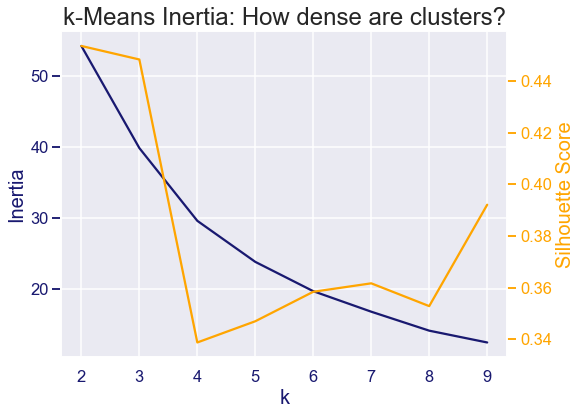

In [413]:
chooseK(co2_gas_full)

$k=3$ has a much higher silhouette score than $k=4$. It doesn't have as dense of clusters though. Let's look at both options.

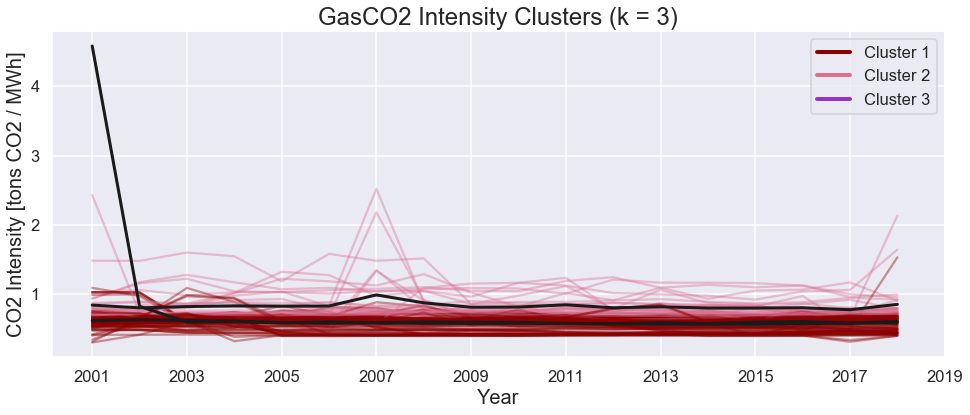

In [411]:
k_means_gas = fitKMeans(co2_gas_full, 3)
plotKMeans(k_means_gas, co2_gas_full, 'Gas')

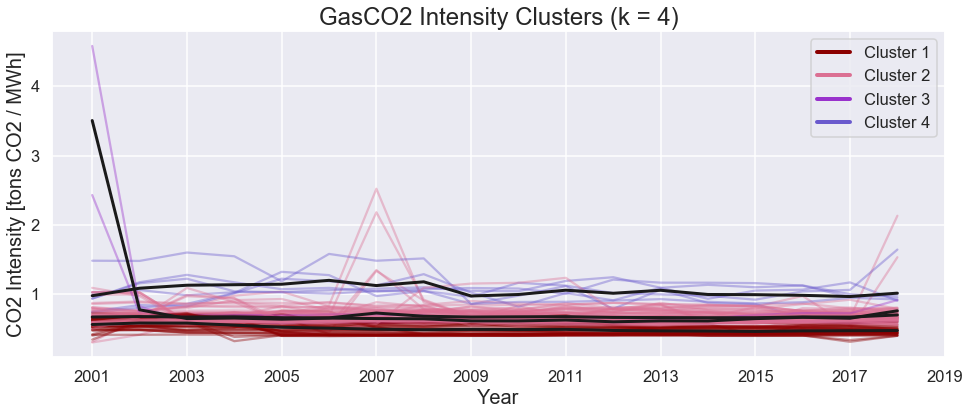

In [414]:
k_means_gas = fitKMeans(co2_gas_full, 4)
plotKMeans(k_means_gas, co2_gas_full, 'Gas')

Clusters are being distressingly dragged upward by a few anomalies. Gonna need to drop a few rows.

That aside, many of the clusters look remarkably constant. This is amazing, given that this group (I assume) includes three types of tech: CCGT, CT, and CHP (cogen)--I do need to check which plants are included though. No trend is clear here.

I also need to come up with a way to include the missing data.

Coal

In [370]:
co2_coal_full = CO2I_coal.dropna().iloc[:, endOfMetadata:]
topOutlier = np.argmax(co2_coal_full['2001'].values)  # max in 2001. One line sits far above the others and takes up a cluster.
topOutlier

36

In [371]:
CO2I_coal.dropna().iloc[36, :]  # probably non-physical. Tiny coal plant in Montana. Drop.

ORISPL_CODE             6089
UNITID                    B1
NAME           Lewis & Clark
FUEL                    coal
GAS                      CO2
2001                 1.54853
2002                 1.48213
2003                  1.4741
2004                 1.48041
2005                  1.4207
2006                 1.37219
2007                 1.46412
2008                 1.38768
2009                  1.2577
2010                 1.23723
2011                 1.24805
2012                 1.20559
2013                 1.22183
2014                 1.38904
2015                 1.34866
2016                 1.29644
2017                 1.35146
2018                 1.38775
Name: 195, dtype: object

In [372]:
CO2I_coal[CO2I_coal['ORISPL_CODE'] == 6089]

,ORISPL_CODE,UNITID,NAME,FUEL,GAS,2001,2002,2003,2004,2005,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
195,6089,B1,Lewis & Clark,coal,CO2,1.548534,1.482134,1.474097,1.480406,1.420702,...,1.257698,1.23723,1.248051,1.205591,1.221831,1.389044,1.348656,1.296437,1.351457,1.387752


In [373]:
co2_coal_full.drop(195, axis=0, inplace=True)

Choosing k

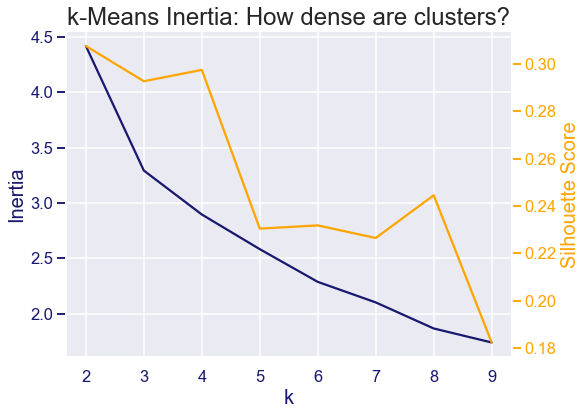

In [379]:
K = range(2, 10)
X = co2_coal_full




Looks like $k=3$ or $k=4$ would serve us well. There is a slight elbow at 3 for inertia. Low inertia is good, but too many clusters compared to the units begins to get unreasonable. Also, the silhouette score is much higher for 4 than 5, which is good. Silhouette score is a measure of the distance from a point in a cluster to its neighbors.

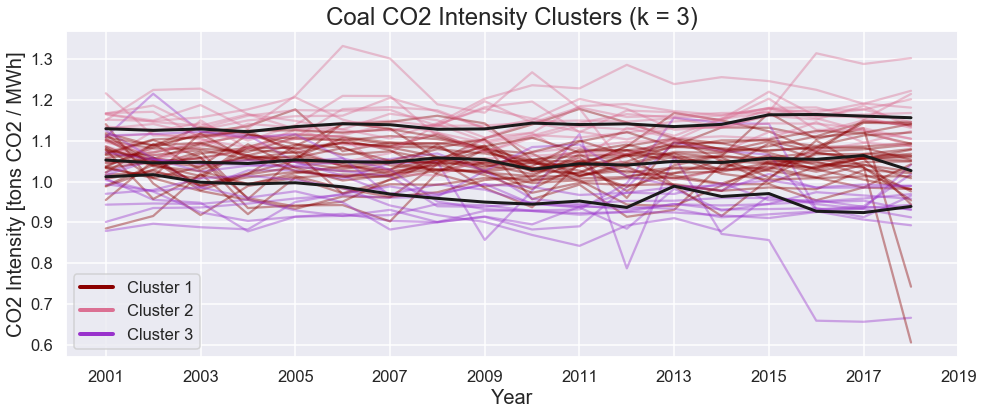

In [388]:
k_means_coal = fitKMeans(co2_coal_full, 3)
plotKMeans(k_means, co2_coal_full, 'Coal')

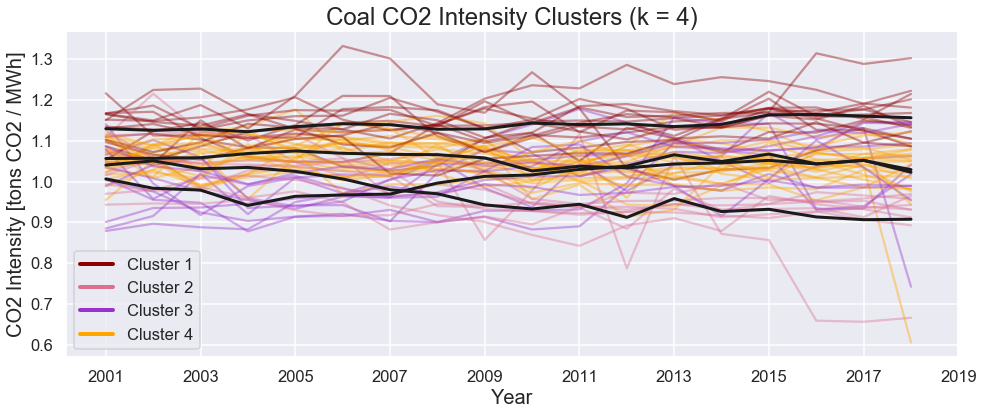

In [390]:
k_means_coal = fitKMeans(co2_coal_full, 4)
plotKMeans(k_means, co2_coal_full, 'Coal')

EDIT: With the outlier removed, some significant differences start to emerge. The highest cluster may be showing a very slight increase. The 2nd from the top is roughly steady. The bottom two flip-flop, indicating some plants are operating less efficiently or changed to a higher intensity fuel source, and some plants did just the opposite.

Unfortunately, we can really see the effect of the outlier taking over the 4th cluster here. We'll have to add one more, or remove it and refit.

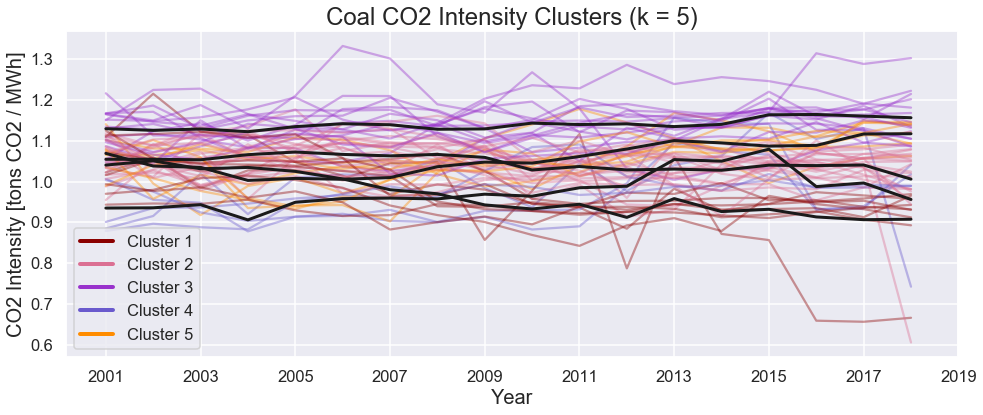

In [393]:
k_means_coal = fitKMeans(co2_coal_full, 5)
plotKMeans(k_means, co2_coal_full, 'Coal')

EDIT: Now a different outlier has overtaken the 5th cluster. We can stick mostly to 4.

We're really trying to focus on trend here. Is the centroid showing an increase or decrease? Note that these will be relatively slight increases. From this plot, it looks like the clusters that start at $1.0$ and $1.17$ $\frac{tons \thinspace{} CO2}{MWh}$ show a slight increase. The cluster that starts 3rd from the bottom (or top) decreases substantially.

In [415]:
k_means_coal.labels_

array([4, 2, 2, 4, 0, 1, 1, 3, 0, 1, 2, 4, 2, 1, 3, 3, 4, 4, 2, 2, 2, 2, 1,
       2, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 3, 4, 4, 2, 1, 2, 2,
       0, 0, 0, 1, 1, 1, 1, 0, 3, 1, 0, 0])

In [251]:
colorDict[labels[10]]

'darkred'

#### Clustering on all available data

Filter out plants for which there is no substantial portion of (2001-09) or (2010-2018). We can't meaningfully use these to determine the difference between the low and high variance periods.

Gas

Coal

##### Hierarchical clustering

In [201]:
# leftover scrap from Coal all units all years plots


# co2_y_max = 1.5
# so2_y_max = 10
# nox_y_max = 6

# fig2 = plt.figure(figsize=(12, 18))
# ax1 = plt.subplot(311)
# for i in range(CO2I_coal.iloc[:, endOfMetadata:].shape[1]):
#     plt.plot(years, CO2I_coal.iloc[i, endOfMetadata:])
# plt.ylim([co2_y_min, co2_y_max])
# plt.xticks(np.linspace(2001, 2019, 10))
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.ylabel('tons CO2 / MWh')
# plt.title('CO2 Intensity')

# ax2 = plt.subplot(312, sharex=ax1)
# for i in range(SO2I_coal.iloc[:, endOfMetadata:].shape[1]):
#     plt.plot(years, SO2I_coal.iloc[i, endOfMetadata:])
# plt.ylim([so2_y_min, so2_y_max])
# plt.xticks(np.linspace(2001, 2019, 10))
# plt.setp(ax2.get_xticklabels(), visible=False)
# plt.ylabel('lbs SO2 / MWh')
# plt.title('SO2 Intensity')

# ax3 = plt.subplot(313, sharex=ax1)
# for i in range(NOXI_coal.iloc[:, endOfMetadata:].shape[1]):
#     plt.plot(years, NOXI_coal.iloc[i, endOfMetadata:])
# plt.ylim([nox_y_min, nox_y_max])
# plt.ylabel('lbs NOX / MWh')
# plt.xticks(np.linspace(2001, 2019, 10))
# plt.title('NOX Intensity')

# plt.suptitle('Coal Units', fontsize=30)
# plt.show()

In [202]:
# # axis limits
# cmap = sns.cm.rocket_r
# co2_color_min = 0
# co2_color_max = co2_y_max
# so2_color_min = so2_y_min
# so2_color_max = 10
# nox_color_min = nox_y_min
# nox_color_max = 6

# # extract data + sort by average
# co2 = CO2I_coal.iloc[:, endOfMetadata:]
# co2['mean'] = co2.mean(axis=1)
# co2.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

# so2 = SO2I_coal.iloc[:, endOfMetadata:]
# so2['mean'] = so2.mean(axis=1)
# so2.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

# nox = NOXI_coal.iloc[:, endOfMetadata:]
# nox['mean'] = nox.mean(axis=1)
# nox.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

# fig3 = plt.figure(figsize=(18, 8))
# ax1 = fig3.add_subplot(311)
# ax1 = sns.heatmap(co2, vmin=co2_color_min, vmax=co2_color_max, cmap=cmap)#, mask=mask)
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.ylabel('Units')
# plt.title('CO2 Intensity Heat Map')

# ax2 = fig3.add_subplot(312)
# ax2 = sns.heatmap(so2, vmin=so2_color_min, vmax=so2_color_max, cmap=cmap)
# plt.setp(ax2.get_xticklabels(), visible=False)
# plt.ylabel('Units')
# plt.title('SO2 Intensity Heat Map')

# ax3 = fig3.add_subplot(313)
# ax3 = sns.heatmap(nox, vmin=nox_color_min, vmax=nox_color_max, cmap=cmap)
# plt.ylabel('Units')
# plt.title('NOX Intensity Heat Map')

# plt.suptitle('Coal Units', fontsize=30)
# plt.show()